# 7. Predicting Personality Index (Frame selection)

In [1]:
from src import *

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer

# Used for scoring argument in fold scoring
def pearson_corrscore(y_true, y_pred):
    ret = pearson_correlation(y_true, y_pred)
    return ret

scoring_method = make_scorer(pearson_corrscore, greater_is_better=True)

D = lambda x,y: ((x-y)**2).sum(axis=1)

In [3]:
# To deal with convergence warnings in sklearn, I know that some weighting search wont allow convergence !!!!!
import sys
import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On full movie Static Gradients](#staticgrad)
- [On frame selected Static Gradients](#fselect-staticgrad)



In [8]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

psy1 = existing_psy[:len(existing_psy)//2]
psy2 = existing_psy[len(existing_psy)//2:]

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On full movie Static Gradients

In [6]:
supermovie_grads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grads.keys())
nsub = len(subjects)

supermovie_dist = {}
rest_dist = {}
for _id in subjects:
    # 1. Movie
    tmp_grads = supermovie_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    supermovie_dist[_id] = dist
    
    # 2. Rest
    tmp_grads = rest_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    rest_dist[_id] = dist

#### Visual difference

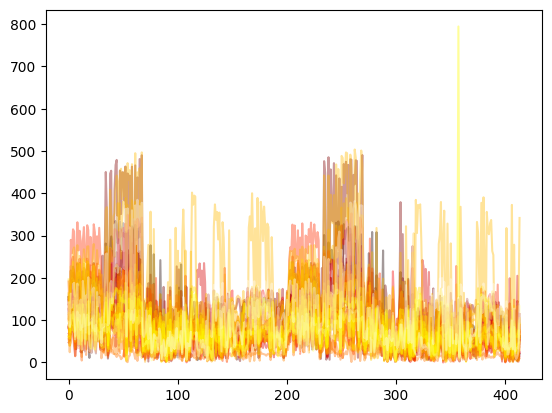

In [7]:
feat = 'cov_total'
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

# for Display
order = np.argsort(psyscore)
ordered_grads = [supermovie_dist[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

#### Regress / Predictive

In [11]:
# across all pidx
pred_corrs = {"movie": {}, "rest":{}}
grads_dist = [supermovie_dist, rest_dist]
for gidx, gtype in enumerate(['movie', 'rest']):
    for feat in tqdm(existing_psy):
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

        X = np.asarray([grads_dist[gidx][subj] for subj in subjects])
        y = np.array(deepcopy(psyscore))

        # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
        n_iter = 300
        list_scores = []

        lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

        for k in range(n_iter):
            rs = k
            # configure the cross-validation procedure
            cv_inner = KFold(n_splits=4, shuffle=True, random_state=rs)
            # define the model
            model = Lasso()
            # define search space
            space = dict()
            space['alpha'] = lambda_grid
            # define search
            search = GridSearchCV(model, space, scoring=scoring_method, n_jobs=1, cv=cv_inner, refit=True)
            # configure the cross-validation procedure
            cv_outer = KFold(n_splits=3, shuffle=True, random_state=rs)
            # execute the nested cross-validation
            scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
            # report performance
            list_scores.append(scores)
        
        pred_corrs[gtype][feat] = list_scores

In [28]:
# save('./resources/regression_logs/supermovie-rest_lasso.pkl', pred_corrs)

In [ ]:
# pred_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')

In [44]:
pred_df = {"type": [], "pidx": [], "corr": []}
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(pred_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

pred_df = pd.DataFrame.from_dict(pred_df)

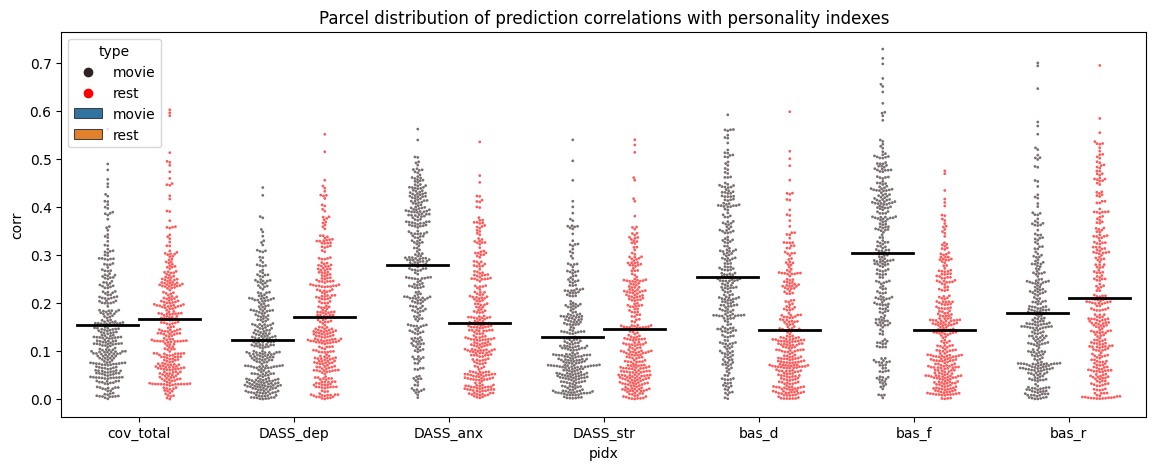

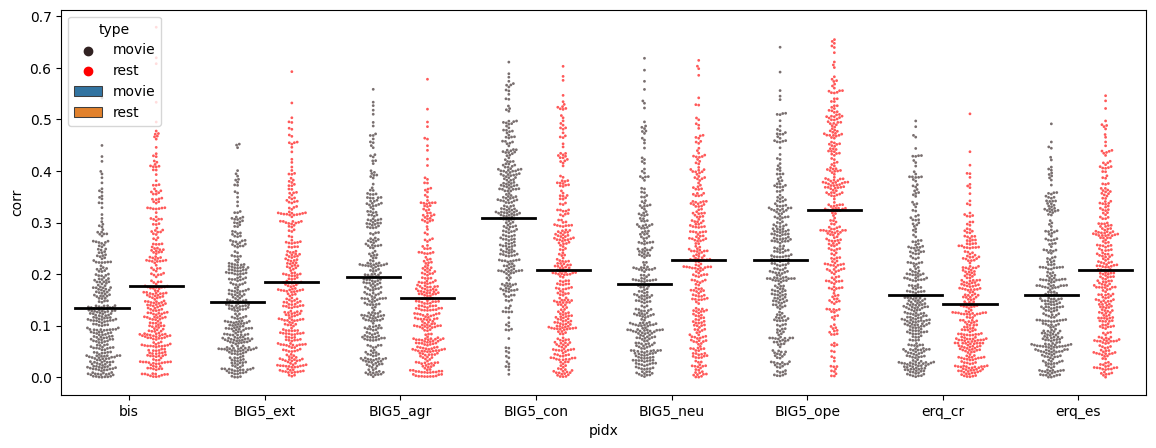

In [45]:
cur_df = pred_df
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
# get rid of duplicate legends
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.title("Parcel distribution of prediction correlations with personality indexes")
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2])
plt.show()

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Static Gradients

In [9]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [10]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [11]:
subjects = list(fselect_supermovie_grads[0][(0,5)].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound

#### Visual difference

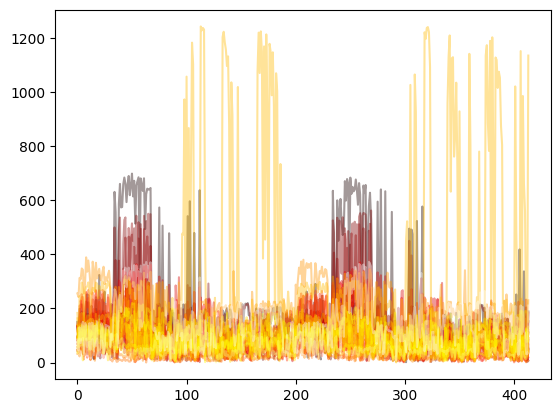

In [12]:
feat = 'cov_total'
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
eg_dist = fselect_supermovie_dists[0][(0,5)]

# for Display
order = np.argsort(psyscore)
ordered_grads = [eg_dist[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

#### Regress / Predictive

In [ ]:
# across all FA(s)
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_dists[fa_nb]
    
    pred_corrs = {key: {} for key in s25+s33+s50}
    for gidx, gtype in enumerate(tqdm(pred_corrs.keys())):
        
        # across all pidx
        for feat in tqdm(existing_psy):
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

            X = np.asarray([tmp_fa[gtype][subj] for subj in subjects])
            y = np.array(deepcopy(psyscore))

            # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
            n_iter = 250 #number of repetitions of nested cross val
            list_scores = []

            # search grid for hyper parameter
            lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]
            
            # Main: cross val Scoring
            for k in range(n_iter):
                rs = k
                # configure the cross-validation procedure
                cv_inner = KFold(n_splits=4, shuffle=True, random_state=rs)
                # define the model
                model = Lasso()
                # define search space
                space = dict()
                space['alpha'] = lambda_grid
                # define search
                search = GridSearchCV(model, space, scoring=scoring_method, n_jobs=1, cv=cv_inner, refit=True)
                # configure the cross-validation procedure
                cv_outer = KFold(n_splits=3, shuffle=True, random_state=rs)
                # execute the nested cross-validation
                scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
                # report performance
                list_scores.append(scores)

            pred_corrs[gtype][feat] = list_scores

    save('./resources/regression_logs/fselect_fa{}_lasso_bis.pkl'.format(fa_nb), pred_corrs)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [46]:
pred_corrs = load('./resources/regression_logs/fselect_fa1_lasso_bis.pkl')

In [47]:
stand_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')

In [50]:
pred_df = {"type": [], "pidx": [], "corr": []}
for _type in s50:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(pred_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

# add rest and movie as a baseline
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.abs(np.asarray(stand_corrs[_type][feat]).mean(axis=1))
        
        pred_df['type'] += [_type] * len(fold_pred)
        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

pred_df = pd.DataFrame.from_dict(pred_df)

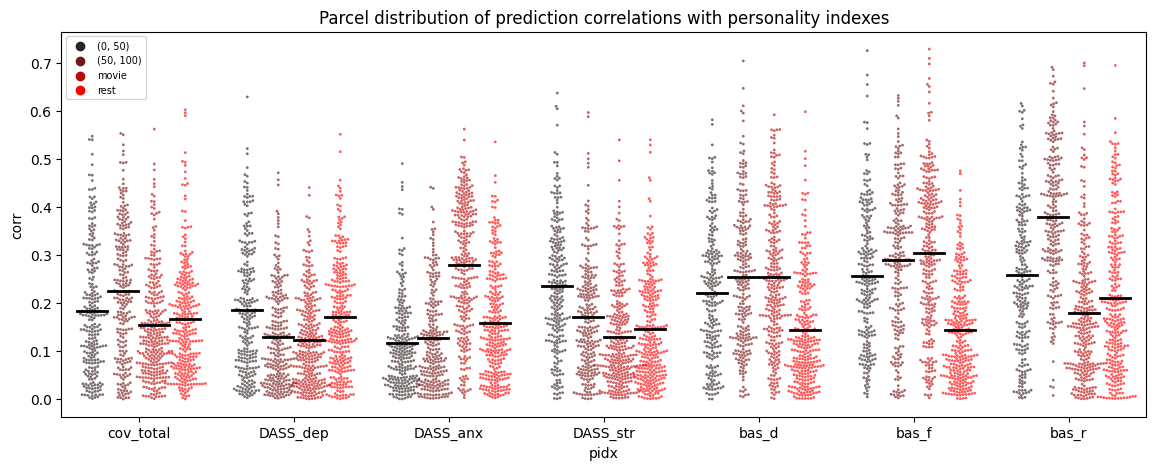

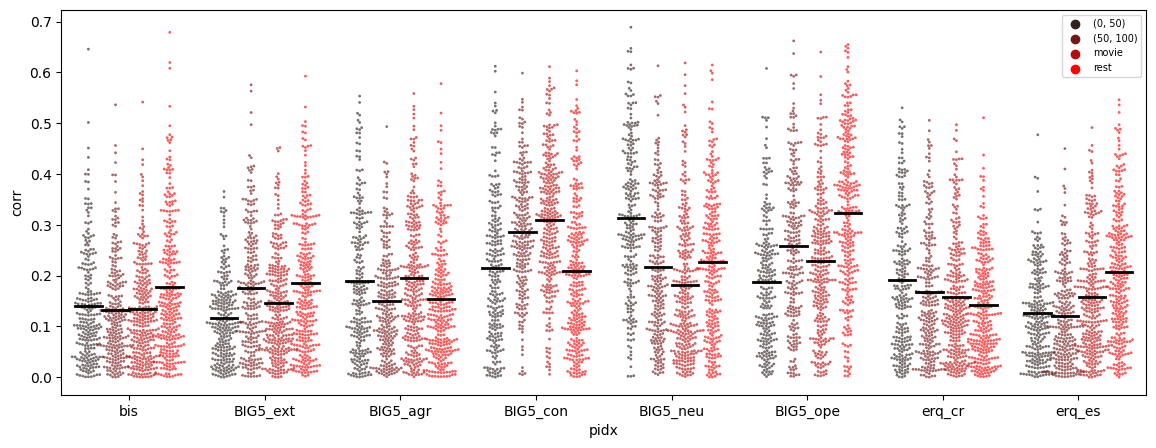

In [51]:
cur_df = pred_df
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size': 7})

plt.title("Parcel distribution of prediction correlations with personality indexes")
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
tmp = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2], labels[:len(handles)//2], prop={'size': 7})

plt.show()

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Network-subset Gradients (with baseline per network of Movie and Film)

In [ ]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [ ]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [ ]:
subjects = list(fselect_supermovie_grads[0][(0,5)].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound